In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

In [30]:
data = pd.read_csv('./dataA.csv')
data.head(1)

,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,Avg_pps,...,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
0,0.364172,-0.700949,-0.804477,-0.943635,-0.31695,-0.898724,-0.625504,0.37276,0.580955,0.446664,...,1,0,0,1,0,0,1,0,0,0


# Best Features

In [31]:
Feature_Selection = ['#dp', '#sp', 'first_dp', 'first_sp', 'min_d', 'p1_d', 'p1_ip',
       'p2_d', 'p2_ip', 'p3_ib', 'second_dp', 'second_sp']

In [32]:
X = data[Feature_Selection]
y = data['Type_mine']

# Holdout

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size=0.3)

In [34]:
model = svm.SVC(probability=True)

In [35]:
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [36]:
y_pred = model.predict(X_test)

([<matplotlib.axis.YTick at 0x15260b1e208>,
 <a list of 2 Text yticklabel objects>)

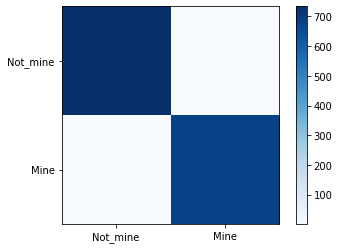

In [37]:
churm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(churm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [38]:
pd.DataFrame(churm)

,0,1
0,733,6
1,2,679


In [39]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa: ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.9943661971830986
Kappa:  0.988716165880308


In [40]:
print(colored('Metricas de los registros mineros', attrs=['bold']))

print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[1], average='macro'))

VP = np.sum(churm[1:2,1:2])
FN = np.sum(churm[1,0:1])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[1], average='macro'))

Metricas de los registros mineros
Precisión     :  0.9912408759124087
Recall        :  0.9970631424375918
Especificidad :  0.9970631424375918
F1-score      :  0.9941434846266471


In [41]:
print(colored('Metricas de los registros no mineros', attrs=['bold']))

print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[0], average='macro'))

VP = np.sum(churm[0:1,0:1])
FN = np.sum(churm[0,1:2])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[0], average='macro'))

Metricas de los registros no mineros
Precisión     :  0.9972789115646259
Recall        :  0.9918809201623816
Especificidad :  0.9918809201623816
F1-score      :  0.994572591587517


In [42]:
y_pred_proba = model.predict_proba(X_test)

In [43]:
lr_probs = y_pred_proba[:,1]

In [44]:
ns_probs = [0 for _ in range(len(y_test))]

In [45]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

0.5

In [46]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

0.9998529584170377

In [47]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('VSM: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
VSM: ROC AUC=1.000


In [48]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

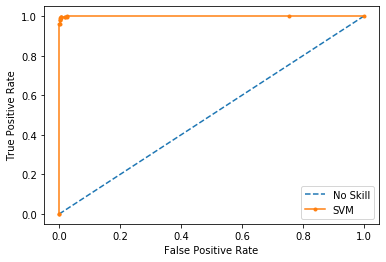

In [49]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()